# Variability analysis for HBEC IFN experiment

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline
import itertools

In [2]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq')
import encode
import memento

In [65]:
pd.set_option('display.max_rows', None)

In [3]:
data_path = '/data_volume/memento/hbec/'
fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig6/'

In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

### Get canonical TFs

In [78]:
tf_df = pd.read_csv('human_tf.txt', sep='\t')
tf_list = tf_df['Symbol'].tolist()
tf_list += ['CIITA']

### Read the processed RNA data

Focus on the club and bc/club cells and type I interferons for now.

Encode the timestamps to integers.

In [8]:
# adata_processed = sc.read(data_path + 'HBEC_type_I_processed_deep.h5ad')

In [9]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

In [10]:
adata = adata[:, ~adata.var.index.str.startswith('MT-')].copy()
# adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'basal/club' else 'bc')
# adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'ionocyte/tuft' else 'ion-tuft')

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [11]:
adata.shape

(69958, 36588)

In [12]:
converter = {'basal/club':'BC', 'basal':'B', 'ciliated':'C', 'goblet':'G', 'ionocyte/tuft':'IT', 'neuroendo':'N'}

In [13]:
adata.obs.cell_type.value_counts()

basal/club       29792
basal            22844
ciliated         15041
goblet            1525
ionocyte/tuft      546
neuroendo          210
Name: cell_type, dtype: int64

In [14]:
adata.obs['ct'] = adata.obs['cell_type'].apply(lambda x: converter[x])

### Setup memento

In [15]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [16]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [17]:
memento.setup_memento(adata, q_column='q')

Version 0.0.6


### Read 1d HT result comparing to control

In [18]:
cts = [['ciliated']]
tps = [ '6',]
stims = ['alpha', 'beta', 'gamma', 'lambda']

In [19]:
def read_result(ct):
    
    ht_dict = {}
    moments_dict = {}
    
    for stim in stims:
        ht_dict[stim] = {}
        moments_dict[stim] = {}
        for tp in tps: 
            adata_subset = sc.read(data_path + '/binary_test_latest/{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp))
            ht_dict[stim][tp] = memento.get_1d_ht_result(adata_subset)
            ht_dict[stim][tp]['de_fdr'] = memento.util._fdrcorrect(ht_dict[stim][tp]['de_pval'])
            ht_dict[stim][tp]['dv_fdr'] = memento.util._fdrcorrect(ht_dict[stim][tp]['dv_pval'])
            moments_dict[stim][tp] = memento.get_1d_moments(adata_subset, groupby='time_step')
    return ht_dict,moments_dict

In [20]:
all_result = {}
for ct in cts:
    
    key = '-'.join(ct)
    all_result[key] = {}
    
    all_result[key]['ht'], all_result[key]['moments'] = read_result(ct)

In [28]:
stims = ['alpha', 'beta', 'gamma', 'lambda']
ct = 'ciliated'
de_genes = {}

for stim in stims:
    de_genes[stim] = all_result[ct]['ht'][stim]['6'].query('de_fdr < 0.1 & de_coef > 0.5').gene.tolist()
de_genes['alpha/beta'] = set(de_genes['alpha']) | set(de_genes['beta'])

stims = ['gamma', 'lambda', 'alpha/beta']
    
uniq_de_genes = {}
for stim in stims:
    
    uniq_de_genes[stim] = set(de_genes[stim])
    for other in stims:
        if stim == other: continue
        uniq_de_genes[stim] -= set(de_genes[other])
    print(stim, len(uniq_de_genes[stim]))

shared_de_genes = set()
for stim in stims:
    if len(shared_de_genes) == 0:
        shared_de_genes = set(de_genes[stim])
    else:
        shared_de_genes &= set(de_genes[stim])

gamma 53
lambda 21
alpha/beta 389


### Differential correlation upon stimulation wtih IFN-$\gamma$

In [36]:
ct = ['ciliated']
stim = 'gamma'

In [81]:
adata_stim = adata.copy()[
    adata.obs.cell_type.isin(ct) & \
    adata.obs.stim.isin(['control', stim])].copy()
# time_converter={0:0, int('6'):1}
adata_stim.obs['time_step'] = adata_stim.obs['time']#.astype(int).apply(lambda x: time_converter[x])
adata_stim.obs['time'] = 'tp_' + adata_stim.obs['time'].astype(str)

memento.create_groups(adata_stim, label_columns=['time', 'donor'])
memento.compute_1d_moments(adata_stim, min_perc_group=.3)
moment_1d_df = memento.get_1d_moments(adata_stim, groupby='time')

available_tfs = list(set(tf_list) & set(moment_1d_df[0].gene))
available_targets = list(uniq_de_genes[stim] & set(moment_1d_df[0].gene))

memento.compute_2d_moments(adata_stim, list(itertools.product(available_tfs, available_targets)))

moment_df = memento.get_2d_moments(adata_stim, groupby='time') 

moment_df['max_corr'] = moment_df.iloc[:, 2:].max(axis=1).values

candidates = moment_df.query('max_corr > 0.35 & gene_1 != gene_2')

top_tfs = candidates.groupby('gene_1').size().sort_values(ascending=False)
top_tfs = top_tfs[top_tfs > 15].index.tolist()

candidates = candidates.query('gene_1 in @top_tfs')

candidates = list(zip(candidates['gene_1'], candidates['gene_2']))

candidates = list(itertools.product(['STAT1', 'IRF1', 'CIITA'], ['HLA-DRA', 'HLA-DMA', 'HLA-DPB1', 'HLA-DRB1']))

memento.compute_2d_moments(adata_stim, candidates)

memento.ht_2d_moments( 
    adata_stim, 
    formula_like='1 + time + donor',
    treatment_col='time', 
    num_boot=10000, 
    verbose=1,
    num_cpus=94,
    resampling='permutation',
    approx=False)


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/estimator.py:105: RuntimeWarning: invalid value encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:523: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:550: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:562: RuntimeWarning: invalid value encountered in true_divide
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:614: RuntimeWarn

In [82]:
ht_2d_df = memento.get_2d_ht_result(adata_stim)
ht_2d_df['corr_fdr'] = memento.util._fdrcorrect(ht_2d_df['corr_pval'])
sig_df = ht_2d_df.query('corr_fdr < 0.1')

In [83]:
tp_order = ['time_tp_' + str(i) for i in [0, 3, 6, 9, 24, 48]]

In [90]:
moment_1d_df[0].query('gene == "CIITA"')[tp_order]

,time_tp_0,time_tp_3,time_tp_6,time_tp_9,time_tp_24,time_tp_48
8497,-2.216917,-0.133482,-0.250962,-0.205729,-0.256063,-0.471048


In [85]:
dra=moment_df.merge(sig_df[['gene_1', 'gene_2']], on=['gene_1', 'gene_2'], how='inner')\
    .query('gene_2.str.startswith("HLA-DRA")', engine='python')[['gene_1', 'gene_2'] + tp_order]

In [87]:
dra

,gene_1,gene_2,time_tp_0,time_tp_3,time_tp_6,time_tp_9,time_tp_24,time_tp_48
3,IRF1,HLA-DRA,0.180688,0.383188,0.566185,0.587024,0.322500,0.138778
7,CIITA,HLA-DRA,0.307537,0.135981,0.344362,0.439568,0.255445,0.193518
11,STAT1,HLA-DRA,0.105812,0.410158,0.499205,0.624468,0.580708,0.287421


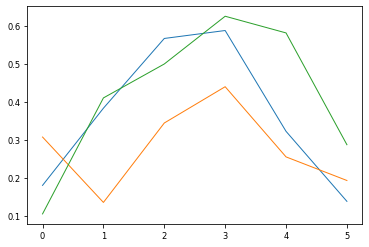

In [86]:
plt.plot(dra[tp_order].values.T, lw=1);